In [1]:
import wrds
import pandas as pd
import numpy as np
import os
import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Get the current working directory
script_dir = os.getcwd()

# Set the working directory to the current script's directory (which in this case is already the working directory)
os.chdir(script_dir)

print(f"Working directory is set to: {script_dir}")

# Connect to WRDS
db = wrds.Connection(wrds_username='zrsong')

# Define the start and end dates
start_date = '2013-01-01'
end_date = '2024-06-30'

overleaf_dir = "/Users/zrsong/Dropbox (MIT)/Apps/Overleaf/Tax Incidence and Loan Contract Negotiations"

Working directory is set to: /Users/zrsong/MIT Dropbox/Zirui Song/Research Projects/MPS_Interest Deductibility and Debt Contracting/4. Code
Loading library list...
Done


In [2]:
tranche_level_ds_compa = pd.read_stata("../3. Data/Processed/tranche_level_ds_compa.dta")
gvkey_list = tranche_level_ds_compa['gvkey'].unique()

In [ ]:
# Initialize an empty list to store DataFrames for each year
yearly_dfs = []

# Loop through years from 2013 to 2023
for year in range(2013, 2024):
    print(f"Processing year {year}...")
    
    # Set start and end dates for the current year
    year_start = f"{year}-01-01"
    year_end = f"{year}-12-31"
    
    # Query the ciq_capstrct.wrds_summary table for the current year
    query = f"""
    SELECT *
    FROM ciq_capstrct.wrds_summary
    WHERE filingdate BETWEEN '{year_start}' AND '{year_end}'
    """
    
    # Execute the query and load the results into a DataFrame
    year_data = db.raw_sql(query)
    
    # Apply filters
    year_data = year_data[year_data['latestforfinancialperiodflag'] == 1]
    year_data = year_data[year_data['periodtypename'] == 'Quarterly']
    year_data = year_data.dropna(subset=['gvkey'])
    year_data['gvkey'] = year_data['gvkey'].str.lstrip('0')
    year_data['gvkey'] = year_data['gvkey'].astype(int)
    
    # Add to the list
    yearly_dfs.append(year_data)
    
    print(f"Year {year} processed. Retrieved {len(year_data)} records.")

# Concatenate all yearly data
capstrct_data = pd.concat(yearly_dfs, ignore_index=True)

print(f"Total records in final dataset: {len(capstrct_data)}")
# Check if 'gvkey' column exists in capstrct_data
if 'gvkey' in capstrct_data.columns:
    print(f"Number of rows in capstrct_data before filtering: {len(capstrct_data)}")
    
    # Keep only the records that are in the gvkey_list
    capstrct_data = capstrct_data[capstrct_data['gvkey'].isin(gvkey_list)]
    
    print(f"Number of rows in capstrct_data after filtering: {len(capstrct_data)}")
else:
    print("Warning: 'gvkey' column not found in capstrct_data")

Processing year 2013...


In [ ]:
# save the data to Processed/csv
capstrct_data.to_csv("../3. Data/Processed/capstrct_data.csv", index=False)

In [3]:
capstrct_data = pd.read_csv("../3. Data/Processed/capstrct_data.csv")

In [4]:
# Sort the capital structure data by gvkey and periodenddate
capstrct_data['periodenddate'] = pd.to_datetime(capstrct_data['periodenddate'])
capstrct_data = capstrct_data.sort_values(by=['gvkey', 'periodenddate'], ascending=[True, True])

# Display information about the sorted data
print(f"Sorted data shape: {capstrct_data.shape}")
print("First few rows of sorted data:")
print(capstrct_data.head())

Sorted data shape: (53379, 121)
First few rows of sorted data:
      companyid  gvkey                        companyname periodenddate  \
2341   296957.0   1075  Pinnacle West Capital Corporation    2011-12-31   
2342   296957.0   1075  Pinnacle West Capital Corporation    2012-03-31   
2343   296957.0   1075  Pinnacle West Capital Corporation    2012-06-30   
2344   296957.0   1075  Pinnacle West Capital Corporation    2012-09-30   
7187   296957.0   1075  Pinnacle West Capital Corporation    2012-12-31   

      periodendtime  filingdate  filingtime  financialinstanceid  \
2341            NaN  2013-02-22         NaN         1.588804e+09   
2342            NaN  2013-05-03         NaN         1.615081e+09   
2343            NaN  2013-08-02         NaN         1.629144e+09   
2344            NaN  2013-10-31         NaN         1.642680e+09   
7187            NaN  2014-02-21         NaN         1.659422e+09   

      financialcollectionid  financialperiodid  ...  \
2341           1.58879

In [5]:
# keep "totbankdbtpct", "totbankdbt" and "gvkey" columns and periodenddate
capstrct_data = capstrct_data[['gvkey', 'periodenddate', 'totsrbondsandnotespct', 'totbankdbtpct', 'totbankdbt']]

/var/folders/n2/pgdf58ms1yd3ch8xjn9fmpmm0000gq/T/ipykernel_25268/395581871.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  avg_bank_debt_pct = capstrct_data.groupby(pd.Grouper(key='periodenddate', freq='Q'))['totbankdbtpct'].mean()


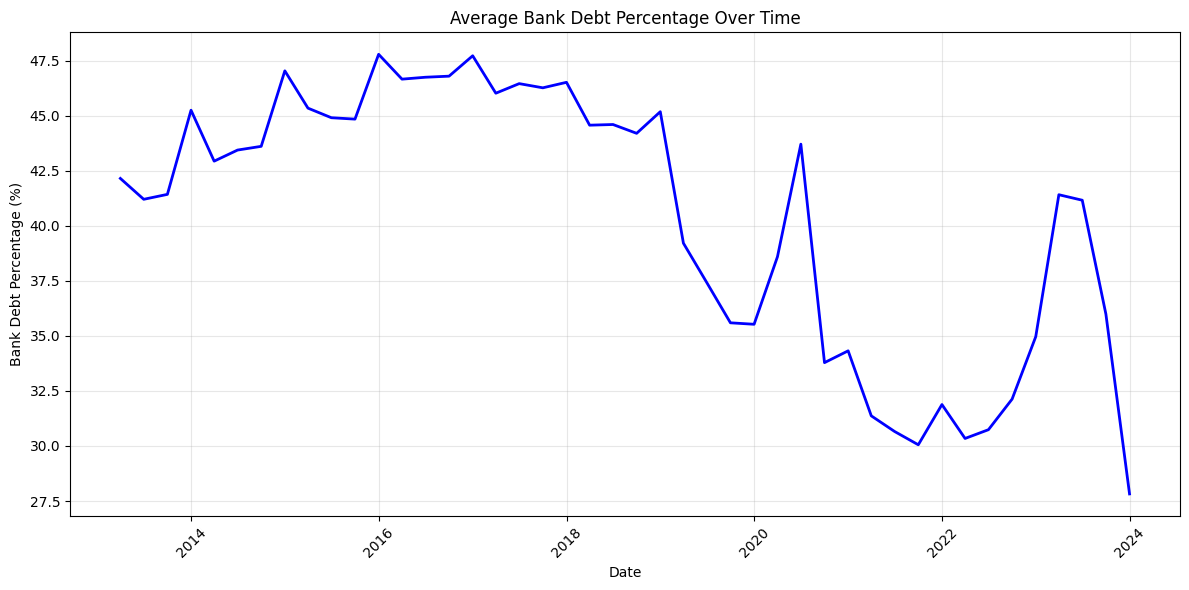

In [6]:
# Group by date and calculate average bank debt percentage, dropping NaN values
avg_bank_debt_pct = capstrct_data.groupby(pd.Grouper(key='periodenddate', freq='Q'))['totbankdbtpct'].mean()
# keep if year is between 2014 and 2023 (+- 1 year to ensure have all data)
avg_bank_debt_pct = avg_bank_debt_pct.loc['2013':'2023']

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(avg_bank_debt_pct.index, avg_bank_debt_pct.values, 'b-', linewidth=2)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Bank Debt Percentage (%)')
plt.title('Average Bank Debt Percentage Over Time')
plt.grid(True, alpha=0.3)

# Improve x-axis formatting
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [7]:
# Extract year and quarter from periodenddate in capstrct_data
capstrct_data['year'] = capstrct_data['periodenddate'].dt.year
capstrct_data['quarter'] = capstrct_data['periodenddate'].dt.quarter

# take the average for each year gvkey
avg_bank_debt_pct = capstrct_data.groupby(['gvkey', 'year'])['totbankdbtpct'].mean().reset_index()
avg_bond_debt_pct = capstrct_data.groupby(['gvkey', 'year'])['totsrbondsandnotespct'].mean().reset_index()

# check for duplicates
duplicates = avg_bank_debt_pct[avg_bank_debt_pct.duplicated(subset=['gvkey', 'year'], keep=False)]
print(f"Number of duplicates: {len(duplicates)}")

Number of duplicates: 0


In [8]:

# Load comp_crspa_merged dataset
comp_crspa_merged = pd.read_csv("../3. Data/Processed/comp_crspa_merged.csv")

# duplicate check
duplicates = comp_crspa_merged[comp_crspa_merged.duplicated(subset=['gvkey', 'fyear'], keep=False)]
print(f"Number of duplicates: {len(duplicates)}")

Number of duplicates: 0


In [9]:

# merge the two datasets based on gvkey and year
merged_data = pd.merge(avg_bank_debt_pct, comp_crspa_merged, left_on=['gvkey', 'year'], right_on=['gvkey', 'fyear'], how='inner')
merged_data = pd.merge(merged_data, avg_bond_debt_pct, left_on=['gvkey', 'year'], right_on=['gvkey', 'year'], how='inner')

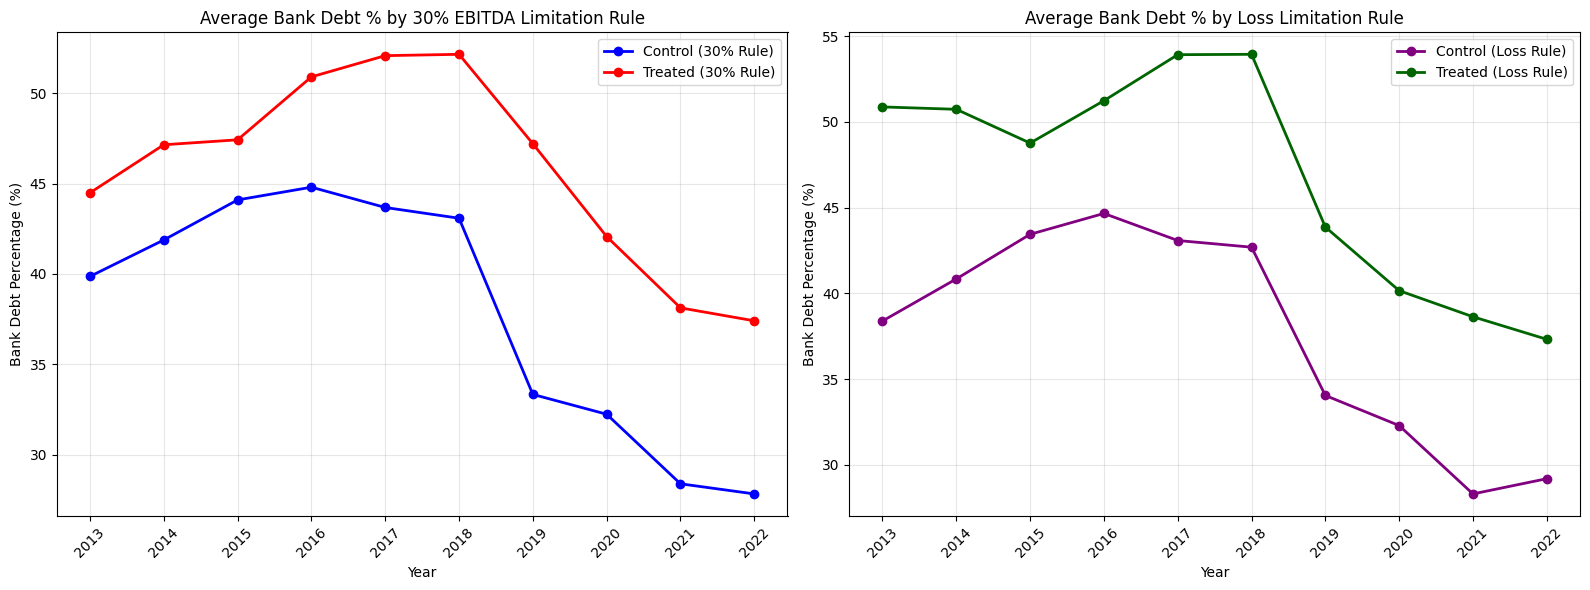

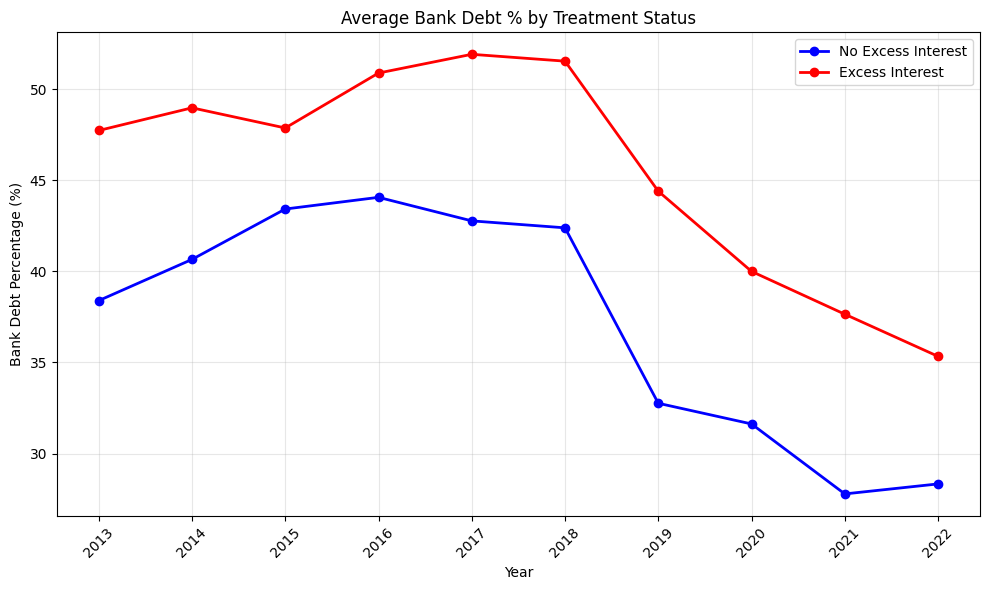

In [10]:
# keep only years between 2014 and 2023 (note that capstrct_data has bunch of missings for year 2023, so drop that too)
merged_data = merged_data[(merged_data['year'] >= 2013) & (merged_data['year'] <= 2022)]

# Calculate yearly averages for each treatment group independently
avg_bank_debt_30 = merged_data.groupby(['year', 'excess_interest_30'])['totbankdbtpct'].mean().reset_index()
avg_bank_debt_loss = merged_data.groupby(['year', 'excess_interest_loss'])['totbankdbtpct'].mean().reset_index()

# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: 30% EBITDA limitation rule
for treated, group_df in avg_bank_debt_30.groupby('excess_interest_30'):
    label = 'Treated (30% Rule)' if treated == 1 else 'Control (30% Rule)'
    color = 'red' if treated == 1 else 'blue'
    ax1.plot(group_df['year'], group_df['totbankdbtpct'], marker='o', label=label, color=color, linewidth=2)

# Plot 2: Loss limitation rule
for treated, group_df in avg_bank_debt_loss.groupby('excess_interest_loss'):
    label = 'Treated (Loss Rule)' if treated == 1 else 'Control (Loss Rule)'
    color = 'darkgreen' if treated == 1 else 'purple'
    ax2.plot(group_df['year'], group_df['totbankdbtpct'], marker='o', label=label, color=color, linewidth=2)

# Configure axes and labels
for ax, title in zip([ax1, ax2], ['30% EBITDA Limitation Rule', 'Loss Limitation Rule']):
    ax.set_xlabel('Year')
    ax.set_ylabel('Bank Debt Percentage (%)')
    ax.set_title(f'Average Bank Debt % by {title}')
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.set_xticks(sorted(merged_data['year'].unique()))
    ax.set_xticklabels(sorted(merged_data['year'].unique()), rotation=45)

plt.tight_layout()
plt.show()
# Create a new variable for firms treated by either rule
merged_data['treated_either'] = ((merged_data['excess_interest_30'] == 1) | 
                                (merged_data['excess_interest_loss'] == 1)).astype(int)

# Calculate yearly averages for the combined treatment group
avg_bank_debt_either = merged_data.groupby(['year', 'treated_either'])['totbankdbtpct'].mean().reset_index()

# Create the plot
plt.figure(figsize=(10, 6))

# Plot for combined treatment rule
for treated, group_df in avg_bank_debt_either.groupby('treated_either'):
    label = 'Excess Interest' if treated == 1 else 'No Excess Interest'
    color = 'red' if treated == 1 else 'blue'
    plt.plot(group_df['year'], group_df['totbankdbtpct'], marker='o', label=label, color=color, linewidth=2)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Bank Debt Percentage (%)')
plt.title('Average Bank Debt % by Treatment Status')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(sorted(merged_data['year'].unique()), rotation=45)

plt.tight_layout()
plt.show()

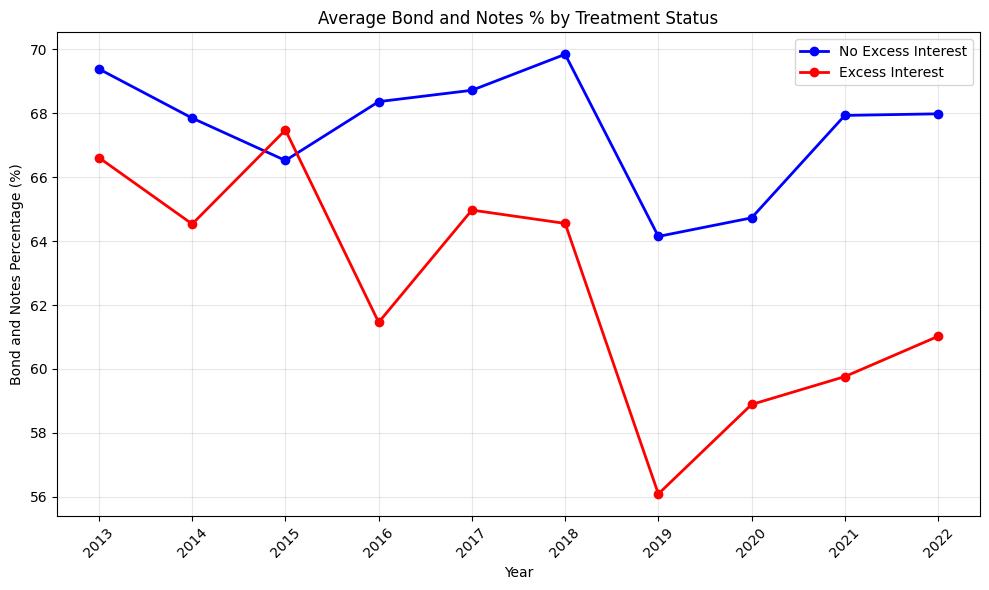

In [15]:
# Calculate yearly averages for the combined treatment group
avg_bond_either = merged_data.groupby(['year', 'treated_either'])['totsrbondsandnotespct'].mean().reset_index()

# Create the plot
plt.figure(figsize=(10, 6))

# Plot for combined treatment rule
for treated, group_df in avg_bond_either.groupby('treated_either'):
    label = 'Excess Interest' if treated == 1 else 'No Excess Interest'
    color = 'red' if treated == 1 else 'blue'
    plt.plot(group_df['year'], group_df['totsrbondsandnotespct'], marker='o', label=label, color=color, linewidth=2)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Bond and Notes Percentage (%)')
plt.title('Average Bond and Notes % by Treatment Status')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(sorted(merged_data['year'].unique()), rotation=45)

plt.tight_layout()
plt.show()

In [16]:
# Sort the data by gvkey, year, and quarter to ensure proper sequencing
merged_data = merged_data.sort_values(by=['gvkey', 'year'])

# Check for duplicates
duplicates = merged_data.duplicated(subset=['gvkey', 'year'], keep=False)
if duplicates.any():
    print(f"Warning: Found {duplicates.sum()} duplicate entries for gvkey-year-quarter combinations")

# Create a groupby object
grouped = merged_data.groupby('gvkey')

# Calculate next 1-year and 2-year earnings
merged_data['ebitda_next_1yr'] = grouped['ebitda'].shift(-1)
merged_data['ebitda_next_2yr'] = grouped['ebitda'].shift(-2)

# Calculate earnings growth rates
merged_data['ebitda_growth_1yr'] = (merged_data['ebitda_next_1yr'] - merged_data['ebitda']) / merged_data['ebitda']
merged_data['ebitda_growth_2yr'] = ((merged_data['ebitda_next_2yr'] / merged_data['ebitda']) ** (1/2) - 1)  # Annualized growth rate

# Replace infinite values (resulting from division by zero) with NaN
merged_data.replace([float('inf'), float('-inf')], float('nan'), inplace=True)

# Import scipy.stats for winsorization

# Winsorize the EBITDA measures and growth rates at the 1% and 99% levels
print(merged_data[['ebitda', 'ebitda_next_1yr', 'ebitda_next_2yr', 'ebitda_growth_1yr', 'ebitda_growth_2yr']].describe())

             ebitda  ebitda_next_1yr  ebitda_next_2yr  ebitda_growth_1yr  \
count  11516.000000     10072.000000      8650.000000       10072.000000   
mean    1490.832862      1550.174155      1620.646214           0.730400   
std     4027.549172      4119.262886      4265.435114          65.022862   
min   -21913.000000    -21913.000000    -21913.000000        -684.803922   
25%       90.300000        95.817750       102.651000          -0.098234   
50%      340.428500       366.523500       390.078000           0.055786   
75%     1161.300000      1231.123750      1302.805500           0.218370   
max    82210.000000     82210.000000     82210.000000        6454.090909   

       ebitda_growth_2yr  
count        8079.000000  
mean            0.133116  
std             0.610104  
min            -0.977225  
25%            -0.040183  
50%             0.062113  
75%             0.192955  
max            23.788038  


Before winsorization:
             ebitda  ebitda_next_1yr  ebitda_next_2yr  ebitda_growth_1yr  \
count  11516.000000     10072.000000      8650.000000       10072.000000   
mean    1490.832862      1550.174155      1620.646214           0.730400   
std     4027.549172      4119.262886      4265.435114          65.022862   
min   -21913.000000    -21913.000000    -21913.000000        -684.803922   
1%      -452.757500      -491.850170      -529.245680          -4.783859   
5%       -12.843250       -11.443450        -9.885950          -0.985006   
25%       90.300000        95.817750       102.651000          -0.098234   
50%      340.428500       366.523500       390.078000           0.055786   
75%     1161.300000      1231.123750      1302.805500           0.218370   
95%     6618.072250      6852.550000      7328.340950           1.084091   
99%    18528.000000     19363.360000     19878.880000           4.791994   
max    82210.000000     82210.000000     82210.000000        6454.

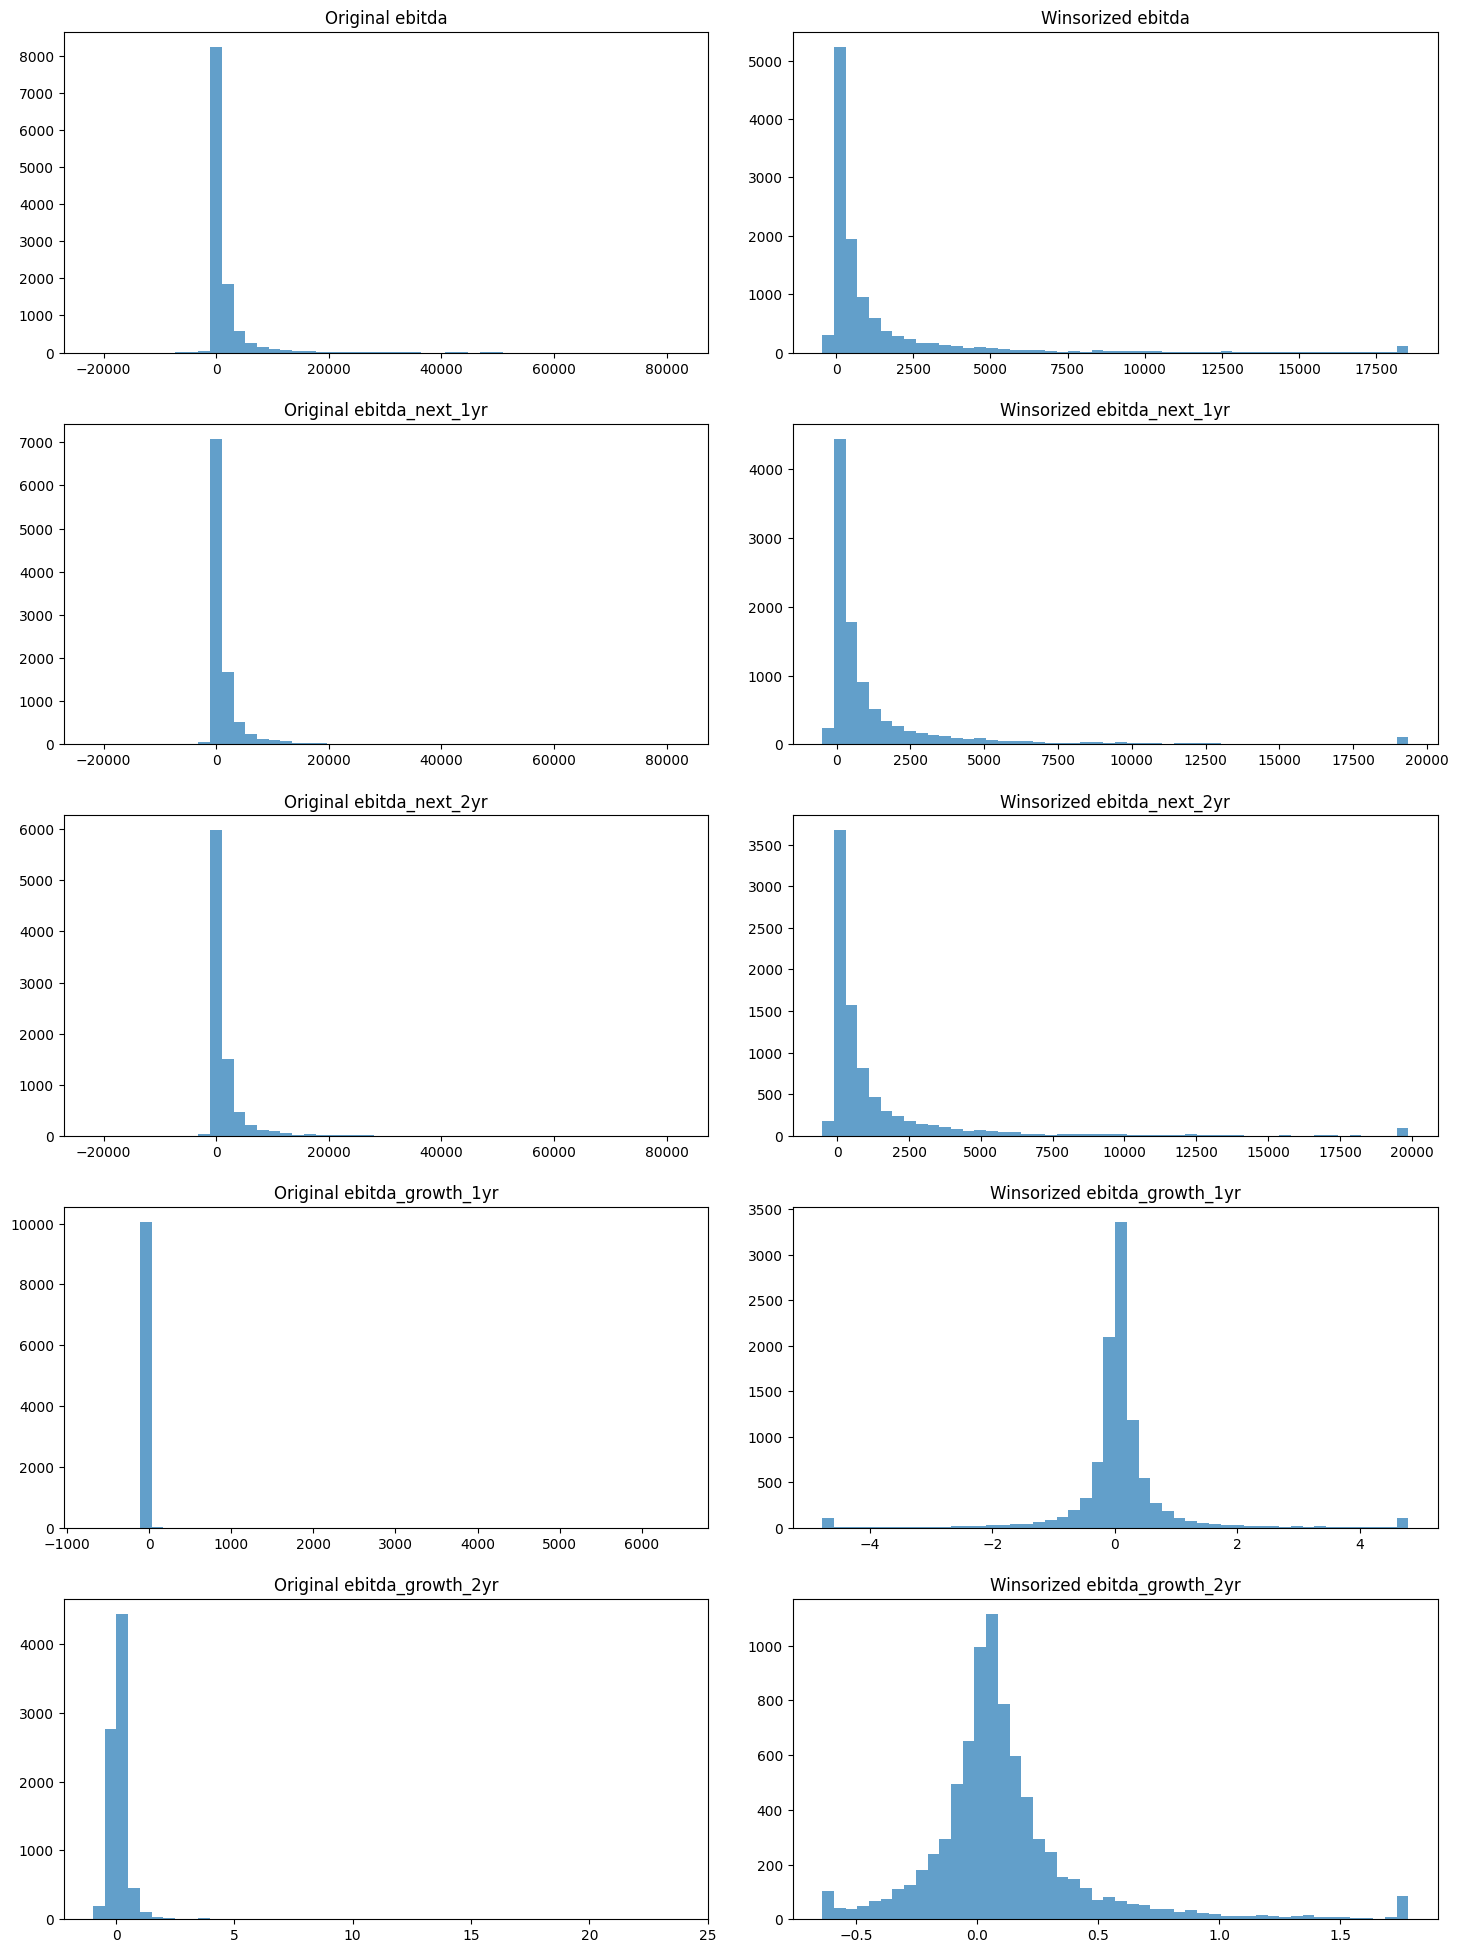

In [17]:
from scipy.stats import mstats

# Import scipy.stats for winsorization

# Show descriptive statistics before winsorization
print("Before winsorization:")
print(merged_data[['ebitda', 'ebitda_next_1yr', 'ebitda_next_2yr', 
                  'ebitda_growth_1yr', 'ebitda_growth_2yr']].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]))

# Columns to winsorize
cols_to_winsorize = ['ebitda', 'ebitda_next_1yr', 'ebitda_next_2yr', 
                     'ebitda_growth_1yr', 'ebitda_growth_2yr']

# Winsorize each column at 1% and 99% levels
for col in cols_to_winsorize:
    if col in merged_data.columns:
        # Get non-missing values
        valid_data = merged_data[col].dropna()
        if len(valid_data) > 0:
            # Calculate 1st and 99th percentiles
            p01 = valid_data.quantile(0.01)
            p99 = valid_data.quantile(0.99)
            
            # Winsorize the data
            merged_data[f'{col}_winsorized'] = merged_data[col].clip(lower=p01, upper=p99)
            
            print(f"\nWinsorization bounds for {col}:")
            print(f"  1% percentile: {p01}")
            print(f"  99% percentile: {p99}")

# Show descriptive statistics after winsorization
print("\nAfter winsorization:")
print(merged_data[[col + '_winsorized' for col in cols_to_winsorize if col + '_winsorized' in merged_data.columns]].describe())

# Create histograms to visualize the effect of winsorization on each variable
fig, axes = plt.subplots(len(cols_to_winsorize), 2, figsize=(15, 4*len(cols_to_winsorize)))
fig.tight_layout(pad=3.0)

# Plot histograms for each variable before and after winsorization
for i, col in enumerate(cols_to_winsorize):
    if col in merged_data.columns and col + '_winsorized' in merged_data.columns:
        # Original data
        axes[i, 0].hist(merged_data[col].dropna(), bins=50, alpha=0.7)
        axes[i, 0].set_title(f'Original {col}')
        
        # Winsorized data
        axes[i, 1].hist(merged_data[col + '_winsorized'].dropna(), bins=50, alpha=0.7)
        axes[i, 1].set_title(f'Winsorized {col}')

plt.show()

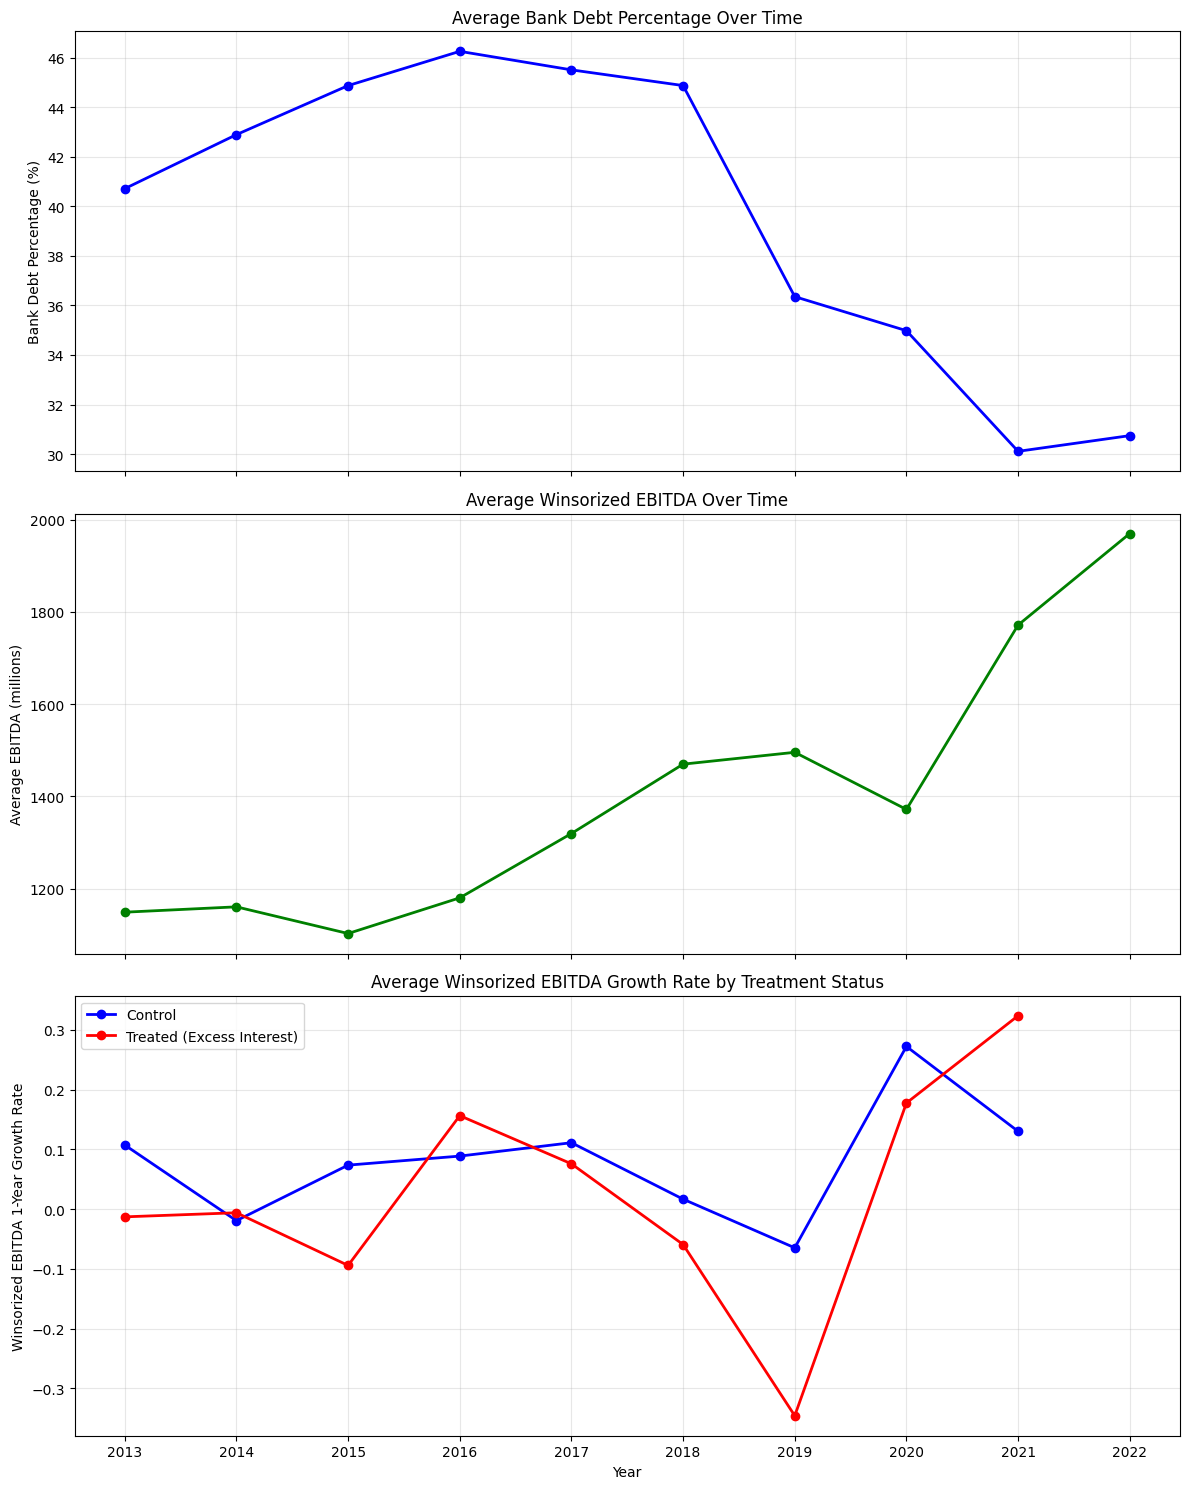

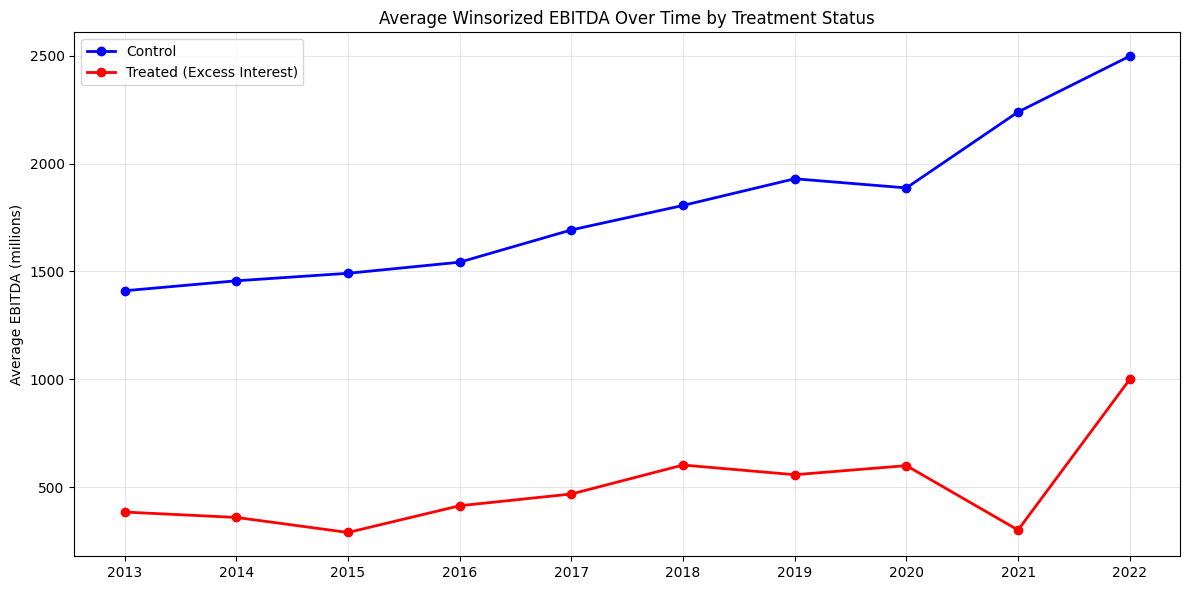

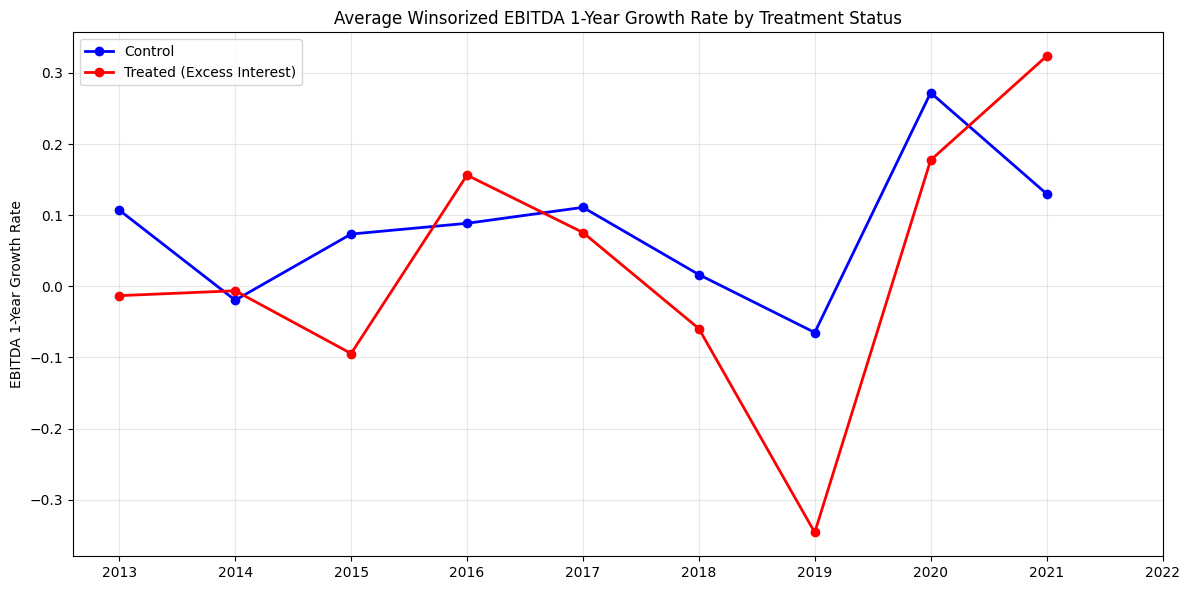

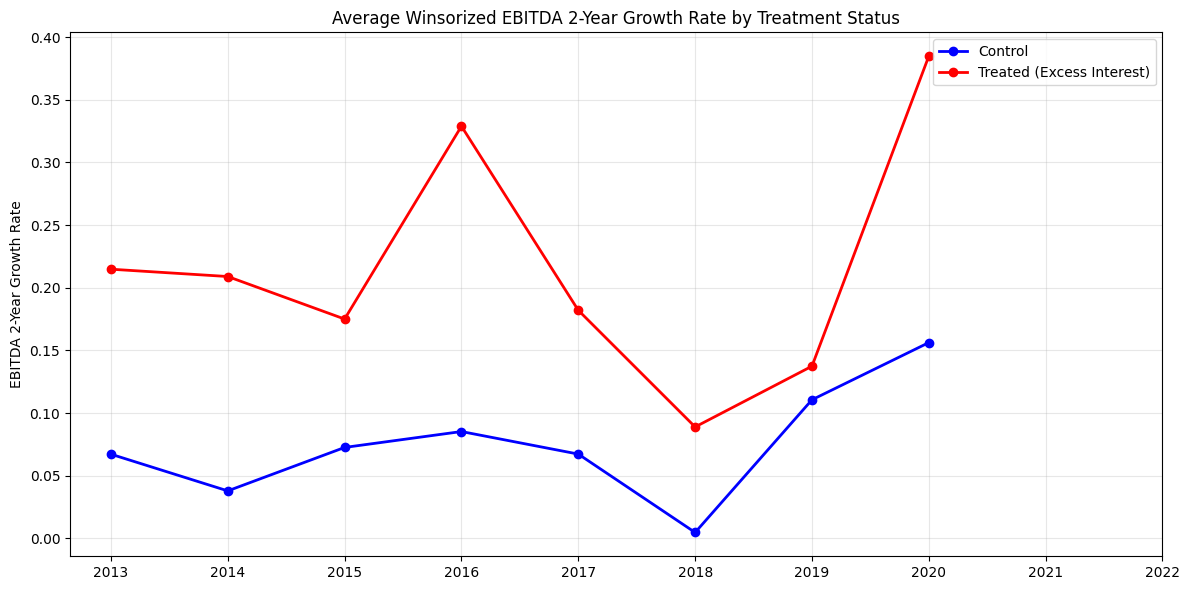

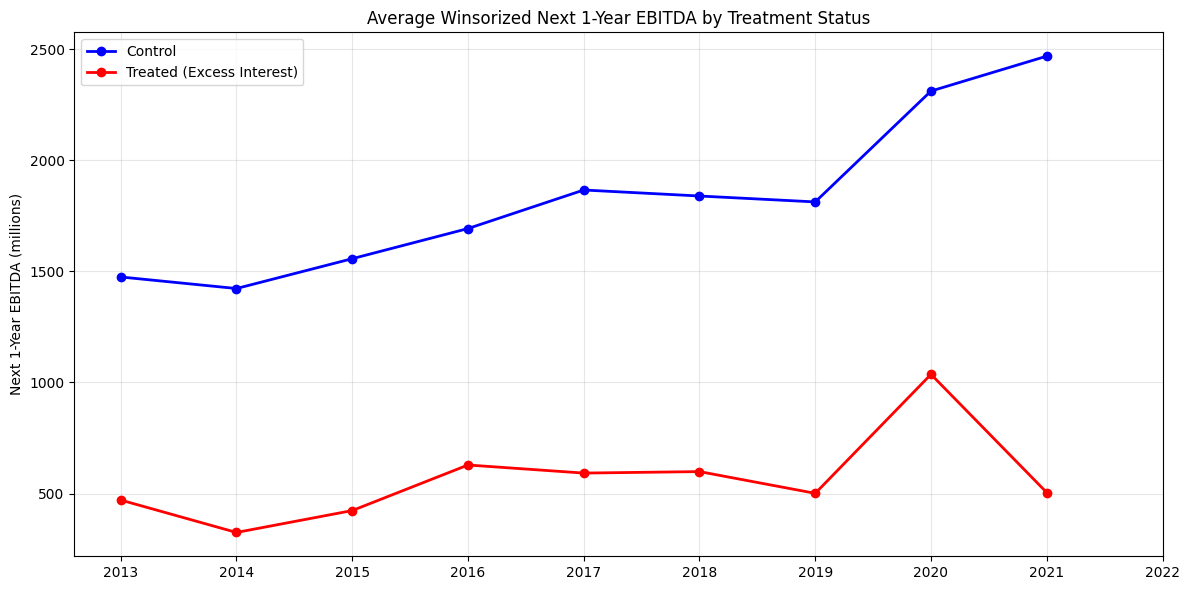

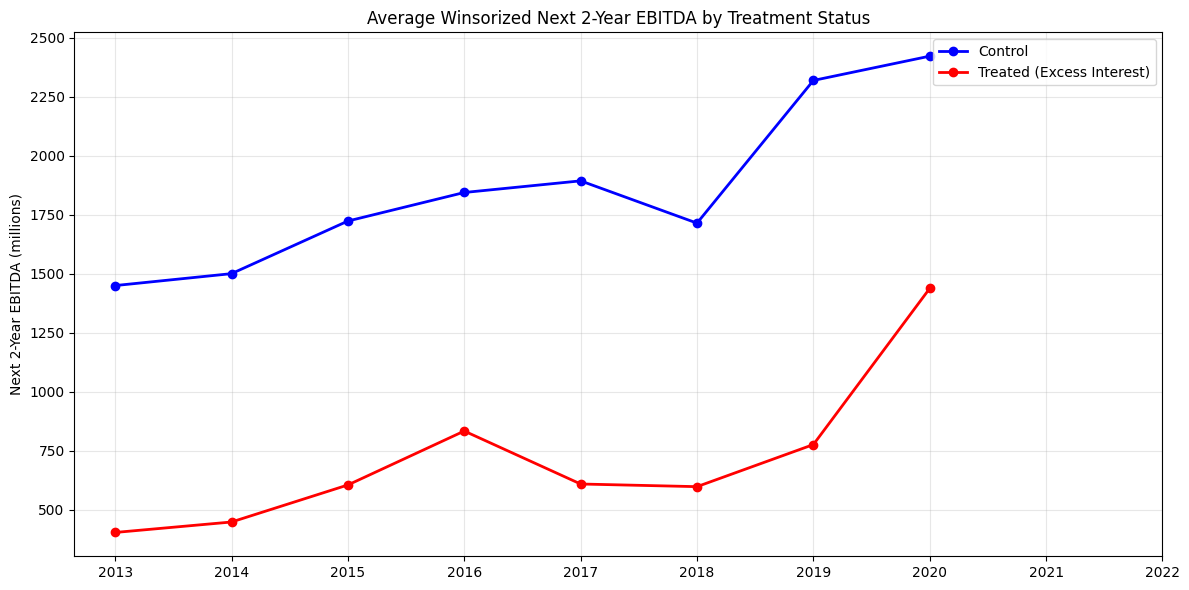

In [18]:
# Create the original figure with three subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

# 1. Plot average bank debt percentage over time
avg_bank_debt = merged_data.groupby('year')['totbankdbtpct'].mean()
axes[0].plot(avg_bank_debt.index, avg_bank_debt.values, 'b-o', linewidth=2)
axes[0].set_ylabel('Bank Debt Percentage (%)')
axes[0].set_title('Average Bank Debt Percentage Over Time')
axes[0].grid(True, alpha=0.3)

# 2. Plot average winsorized EBITDA over time
avg_ebitda = merged_data.groupby('year')['ebitda_winsorized'].mean()
axes[1].plot(avg_ebitda.index, avg_ebitda.values, 'g-o', linewidth=2)
axes[1].set_ylabel('Average EBITDA (millions)')
axes[1].set_title('Average Winsorized EBITDA Over Time')
axes[1].grid(True, alpha=0.3)

# 3. Plot average 1-year winsorized EBITDA growth rate by treatment status
for treated, group_df in merged_data.groupby('treated_either'):
    label = 'Treated (Excess Interest)' if treated == 1 else 'Control'
    color = 'red' if treated == 1 else 'blue'
    avg_growth = group_df.groupby('year')['ebitda_growth_1yr_winsorized'].mean()
    axes[2].plot(avg_growth.index, avg_growth.values, marker='o', label=label, color=color, linewidth=2)

axes[2].set_ylabel('Winsorized EBITDA 1-Year Growth Rate')
axes[2].set_title('Average Winsorized EBITDA Growth Rate by Treatment Status')
axes[2].grid(True, alpha=0.3)
axes[2].legend()
axes[2].set_xlabel('Year')

# Set x-axis ticks to show all years
all_years = sorted(merged_data['year'].unique())
plt.xticks(all_years)
plt.tight_layout()
plt.show()

# Create additional figures for EBITDA comparison
plt.figure(figsize=(12, 6))
for treated, group_df in merged_data.groupby('treated_either'):
    label = 'Treated (Excess Interest)' if treated == 1 else 'Control'
    color = 'red' if treated == 1 else 'blue'
    avg_ebitda = group_df.groupby('year')['ebitda_winsorized'].mean()
    plt.plot(avg_ebitda.index, avg_ebitda.values, marker='o', label=label, color=color, linewidth=2)

plt.ylabel('Average EBITDA (millions)')
plt.title('Average Winsorized EBITDA Over Time by Treatment Status')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(all_years)
plt.tight_layout()
plt.show()

# Create figure for EBITDA 1-year growth rate
plt.figure(figsize=(12, 6))
for treated, group_df in merged_data.groupby('treated_either'):
    label = 'Treated (Excess Interest)' if treated == 1 else 'Control'
    color = 'red' if treated == 1 else 'blue'
    avg_growth = group_df.groupby('year')['ebitda_growth_1yr_winsorized'].mean()
    plt.plot(avg_growth.index, avg_growth.values, marker='o', label=label, color=color, linewidth=2)

plt.ylabel('EBITDA 1-Year Growth Rate')
plt.title('Average Winsorized EBITDA 1-Year Growth Rate by Treatment Status')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(all_years)
plt.tight_layout()
plt.show()

# Create figure for EBITDA 2-year growth rate
plt.figure(figsize=(12, 6))
for treated, group_df in merged_data.groupby('treated_either'):
    label = 'Treated (Excess Interest)' if treated == 1 else 'Control'
    color = 'red' if treated == 1 else 'blue'
    avg_growth = group_df.groupby('year')['ebitda_growth_2yr_winsorized'].mean()
    plt.plot(avg_growth.index, avg_growth.values, marker='o', label=label, color=color, linewidth=2)

plt.ylabel('EBITDA 2-Year Growth Rate')
plt.title('Average Winsorized EBITDA 2-Year Growth Rate by Treatment Status')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(all_years)
plt.tight_layout()
plt.show()

# Create figure for next 1-year EBITDA by treatment status
plt.figure(figsize=(12, 6))
for treated, group_df in merged_data.groupby('treated_either'):
    label = 'Treated (Excess Interest)' if treated == 1 else 'Control'
    color = 'red' if treated == 1 else 'blue'
    avg_next_1yr = group_df.groupby('year')['ebitda_next_1yr_winsorized'].mean()
    plt.plot(avg_next_1yr.index, avg_next_1yr.values, marker='o', label=label, color=color, linewidth=2)

plt.ylabel('Next 1-Year EBITDA (millions)')
plt.title('Average Winsorized Next 1-Year EBITDA by Treatment Status')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(all_years)
plt.tight_layout()
plt.show()

# Create figure for next 2-year EBITDA by treatment status
plt.figure(figsize=(12, 6))
for treated, group_df in merged_data.groupby('treated_either'):
    label = 'Treated (Excess Interest)' if treated == 1 else 'Control'
    color = 'red' if treated == 1 else 'blue'
    avg_next_2yr = group_df.groupby('year')['ebitda_next_2yr_winsorized'].mean()
    plt.plot(avg_next_2yr.index, avg_next_2yr.values, marker='o', label=label, color=color, linewidth=2)

plt.ylabel('Next 2-Year EBITDA (millions)')
plt.title('Average Winsorized Next 2-Year EBITDA by Treatment Status')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(all_years)
plt.tight_layout()
plt.show()

In [19]:
# save the data to Processed/csv
merged_data.to_csv("../3. Data/Processed/capstrct_2013to2022.csv", index=False)